In [47]:
import pandas as pd
import numpy as np

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import cross_validate


In [48]:
# ucitavanje podataka iz CSV fajla
ratings_all = pd.read_csv('ml-latest/ratings.csv')
ratings = ratings_all.head(10000).copy()

ratings.drop(['timestamp'], axis=1, inplace=True)

In [49]:
# brojimo samo razlicite 
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

num_users = len(user_ids)
num_movies = len(movie_ids)

user_id_map = {user_id: index for index, user_id in enumerate(user_ids)}
movie_id_map = {movie_id: index for index, movie_id in enumerate(movie_ids)}

# mapiranje movieId na indekse
movie_id_to_index = {movie_id: index for index, movie_id in enumerate(movie_ids)}

In [50]:
# kvadratna matrica susedstva sa svim korisnicima i filmovima (cak i kada nemaju ocene)
adjacency_matrix = np.zeros((num_users, num_users), dtype=float)

# vrednosti u matrici susedstva
for _, row in ratings.iterrows():
    user_index = user_id_map[row['userId']]
    movie_id = row['movieId']
    movie_index = movie_id_to_index.get(movie_id)
    if movie_index is not None:
        rating = row['rating']
        adjacency_matrix[user_index][user_index] = rating

In [51]:
# primenjujemo spektralnu analizu na matricu susedstva
n_components = 10

# pretvaramo u CSR format radi efikasnije spektralne analize
adjacency_sparse = csr_matrix(adjacency_matrix)  
# LM znaci da uzimamo najveće sopstvene vrednosti
_, eigenvectors = eigs(adjacency_sparse, k=n_components, which='LM')  

# matrica predstavlja ugnjezdena svojstva korisnika i filmova
user_embeddings = eigenvectors

# priprema podataka za biblioteku surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# instanca modela kolaborativnog filtriranja (na primer, KNNBasic)
model = KNNBasic()

# ucenje modela na trening podacima
trainset = data.build_full_trainset()
model.fit(trainset)



Computing the msd similarity matrix...
Done computing similarity matrix.


In [52]:
# predvidjanje ocena korisnika za filmove
def predict_ratings(user_id, movie_id):
    user_index = user_id_map[user_id]
    
    # Pristupamo ugnježdenom vektoru korisnika
    user_embedding = user_embeddings[user_index]
    
    # Implementirajte algoritam za predviđanje ocena na osnovu ugnježdenih vektora
    predicted_rating = np.dot(user_embedding, user_embedding)  # Primer, ovde možete dodati svoj algoritam
    
    return predicted_rating


In [53]:
# evaluacija performansi modela
true_ratings = ratings['rating'].values
predicted_ratings_spectral = []

for _, row in ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    predicted_rating = predict_ratings(user_id, movie_id)
    predicted_ratings_spectral.append(predicted_rating)

predicted_ratings_spectral = np.real(predicted_ratings_spectral)

rmse_spectral = np.sqrt(mean_squared_error(true_ratings, predicted_ratings_spectral))
print("RMSE (Spectral):", rmse_spectral)

# evaluacija performansi modela kolaborativnog filtriranja
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


RMSE (Spectral): 3.667405694613039
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0577  1.0701  1.0720  1.0402  1.0481  1.0576  0.0123  
MAE (testset)     0.8087  0.8091  0.8138  0.7943  0.7923  0.8036  0.0087  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([1.05767113, 1.0701464 , 1.07199223, 1.0402009 , 1.04809927]),
 'test_mae': array([0.8087485 , 0.80906673, 0.81381806, 0.79429568, 0.79231056]),
 'fit_time': (0.0019321441650390625,
  0.00146484375,
  0.0011379718780517578,
  0.0010862350463867188,
  0.0011830329895019531),
 'test_time': (0.023408174514770508,
  0.01790308952331543,
  0.017715930938720703,
  0.01749587059020996,
  0.01764512062072754)}

In [54]:
# transponujemo matricu za filmove
adjacency_sparse_movies = csr_matrix(adjacency_matrix.T) 
_, eigenvectors_movies = eigs(adjacency_sparse_movies, k=n_components, which='LM')  

# matrica predstavlja ugnjezdena svojstva filmova
movie_embeddings = eigenvectors_movies

In [55]:
# ucitavanje podataka iz CSV fajla
movies = pd.read_csv('ml-latest/movies.csv')

print('movies.csv : (vrste, kolone): ', movies.shape)

movies.csv : (vrste, kolone):  (86537, 3)


In [56]:
def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [57]:
movies["clean_title"] = movies["title"].apply(clean_title)
movies.head()

,movieId,title,genres,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale 1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II 1995


In [77]:
# generisanje preporuka za odredjenog korisnika
def generate_recommendations(user_id, user_embeddings, movie_embeddings, k = 10):
    # ugnjezdeni vektor korisnika
    user_index = user_id_map[user_id]
    user_embedding = user_embeddings[user_index]
    
    # slicnost korisnika sa svim filmovima
    similarities = np.dot(movie_embeddings, user_embedding)
    
    # sortiranje filmov po slicnosti u opadajucem redosledu
    top_movie_indices = np.argsort(similarities)[::-1]
    
    # izdvajamo top k filmova kao preporuke
    top_movie_indices = top_movie_indices[:k]
    
    # top k filmova
    recommended_movies = []
    for movie_index in top_movie_indices:
        movie_id = movie_ids[movie_index]
        movie_title = movies[movies['movieId'] == movie_id]['clean_title'].values[0]
        predicted_rating = predict_ratings(user_id, movie_id)
        recommended_movies.append({'movieId': movie_id, 'title': movie_title, 'predicted_rating': predicted_rating})
    
    
    recommended_movies.sort(key=lambda x: x['predicted_rating'], reverse=True)
    
    return recommended_movies

In [91]:
user_id_to_recommend = 2
recommendations = generate_recommendations(user_id_to_recommend, user_embeddings, movie_embeddings)

for i, movie in enumerate(recommendations, 1):
    print(f"{i}. {movie['title']} (ID: {movie['movieId']})")



1. Net The 1995 (ID: 185)
2. Sixth Sense The 1999 (ID: 2762)
3. IQ 1994 (ID: 252)
4. Star Wars Episode VI  Return of the Jedi 1983 (ID: 1210)
5. Apollo 13 1995 (ID: 150)
6. Rob Roy 1995 (ID: 151)
7. In America 2002 (ID: 7139)
8. Star Trek IV The Voyage Home 1986 (ID: 1376)
9. Lord of the Rings The Return of the King The 2003 (ID: 7153)
10. Natural Born Killers 1994 (ID: 288)


In [92]:
def top_rated_movies_for_user(user_id, n=10):
    # Filtriranje ocena datog korisnika
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Sortiranje ocena po oceni u opadajućem redosledu
    user_ratings_sorted = user_ratings.sort_values(by='rating', ascending=False)
    
    # Ispisivanje top n ocena sa nazivima filmova
    top_rated_movies = user_ratings_sorted.head(n)
    
    # Dodavanje naziva filmova na osnovu movieId
    top_rated_movies_with_titles = top_rated_movies.merge(movies[['movieId', 'title']], on='movieId', how='inner')
    
    return top_rated_movies_with_titles

user_id = 2 
top_rated_movies = top_rated_movies_for_user(user_id)
print("Top 10 ocenjenih filmova za korisnika", user_id, "su:")
for index, row in top_rated_movies.iterrows():
    print(f"{index+1}. {row['title']}  (ID: {row['movieId']})")


Top 10 ocenjenih filmova za korisnika 2 su:
1. Toy Story (1995)  (ID: 1)
2. Seven (a.k.a. Se7en) (1995)  (ID: 47)
3. Pulp Fiction (1994)  (ID: 296)
4. Shawshank Redemption, The (1994)  (ID: 318)
5. While You Were Sleeping (1995)  (ID: 339)
6. Forrest Gump (1994)  (ID: 356)
7. Four Weddings and a Funeral (1994)  (ID: 357)
8. Rob Roy (1995)  (ID: 151)
9. Apollo 13 (1995)  (ID: 150)
10. Birdcage, The (1996)  (ID: 141)


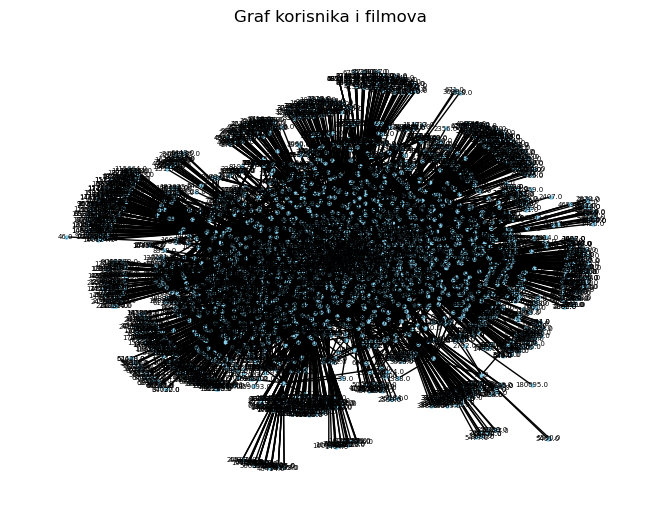

In [61]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for _, row in ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    G.add_edge(user_id, movie_id)

# Crtanje grafa
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=5, node_color='skyblue', font_size=5, font_color='black')
plt.title('Graf korisnika i filmova')
plt.show()